## Learning to rank with LambdaMART

In this notebook we apply the LambdaMART, a pairwise learning to rank method, to a text search data set. We use the XGBoost implementation of LambdaMART. 

In [54]:
import numpy as np
import pickle
import xgboost as xgb
import graphviz
import matplotlib
import math

## Data

The data we use is the Microsoft MSLR-10K dataset, and can be downloaded [here](https://www.microsoft.com/en-us/research/project/mslr/).

The data is a LETOR data set, of the form: "reference lable (ie ranking given by human), query id, query-url pairs (length 136 feature vec)".

The data has been pre-processed by a bash script. 

In [2]:
training_data = xgb.DMatrix('../LearningToRank/MSLR-WEB10K/Fold1/train_dat.txt')
testing_data = xgb.DMatrix('../LearningToRank/MSLR-WEB10K/Fold1/test_dat.txt')

[16:49:45] 723412x137 matrix with 98384032 entries loaded from ../LearningToRank/MSLR-WEB10K/Fold1/train_dat.txt
[16:49:45] 6000 groups are loaded from ../LearningToRank/MSLR-WEB10K/Fold1/train_dat.txt.group
[16:49:46] 241521x137 matrix with 32846856 entries loaded from ../LearningToRank/MSLR-WEB10K/Fold1/test_dat.txt
[16:49:46] 2000 groups are loaded from ../LearningToRank/MSLR-WEB10K/Fold1/test_dat.txt.group


## Building a Model

We now set the model parameters:

'max_depth' = number of layers in the tree
'eta' = step shrinkage size, used to prevent overfitting
'silent' = if 1, doesn't print updates. 
'objective' = which method is used/which objective function is minimised. 'rank:pairwise' implements LambdaMART.
'num_round' = number of boosting rounds. 

In [3]:
param = {'max_depth':6, 'eta':0.3, 'silent':0, 'objective':'rank:pairwise', 'num_round':10}


In [4]:
model = xgb.train(param, training_data)

[16:50:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:50:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:50:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:50:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:50:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:50:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:50:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:51:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:51:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

## Visualising the model

In [5]:
%matplotlib inline

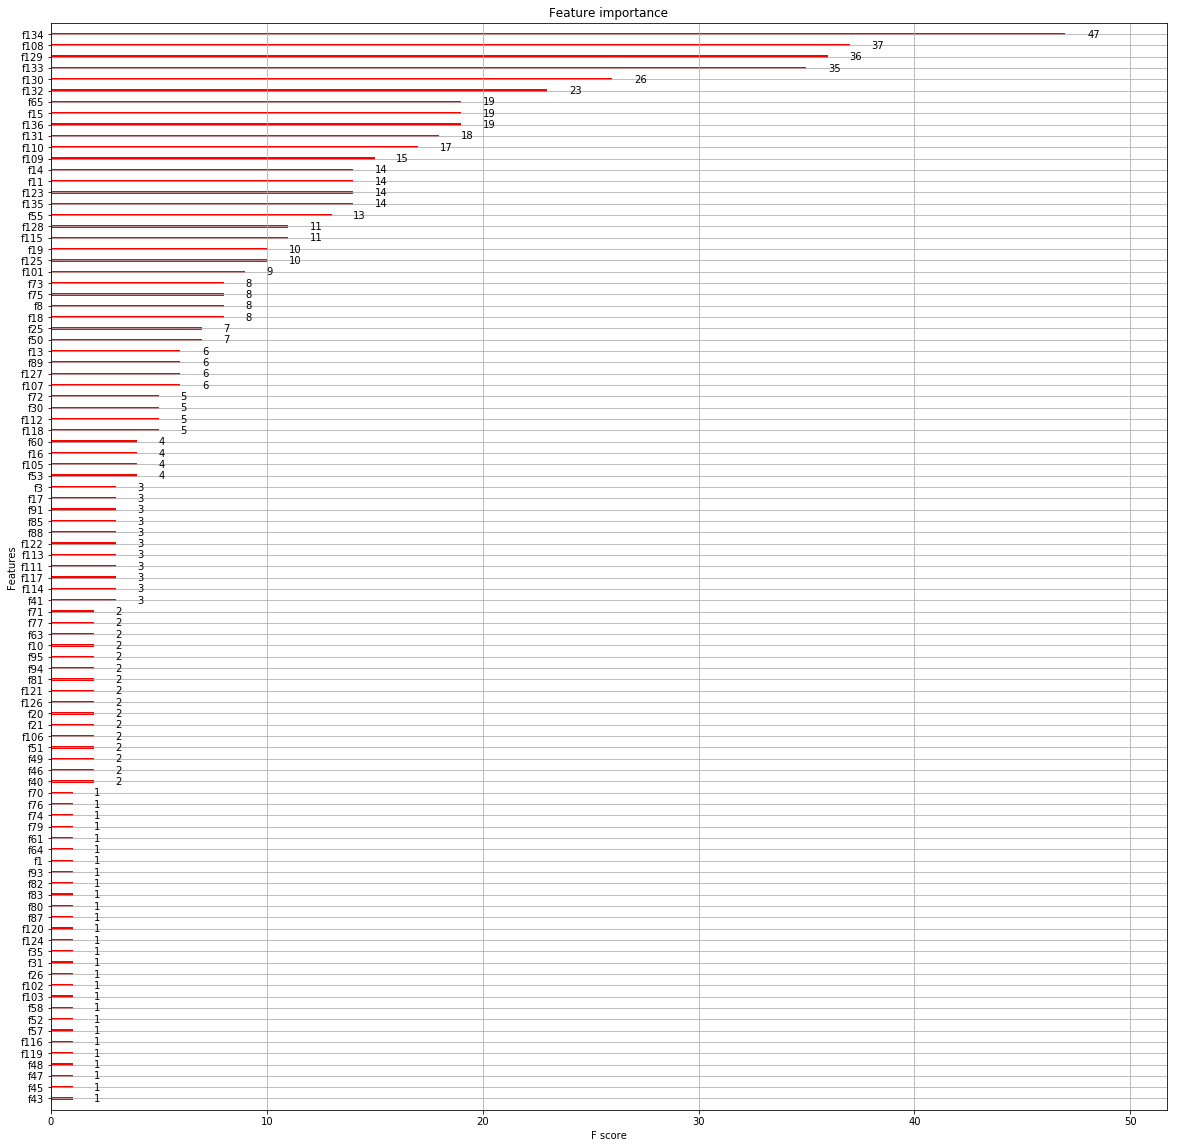

In [6]:
ax = xgb.plot_importance(model, color='red')
fig = ax.figure
fig.set_size_inches(20, 20)

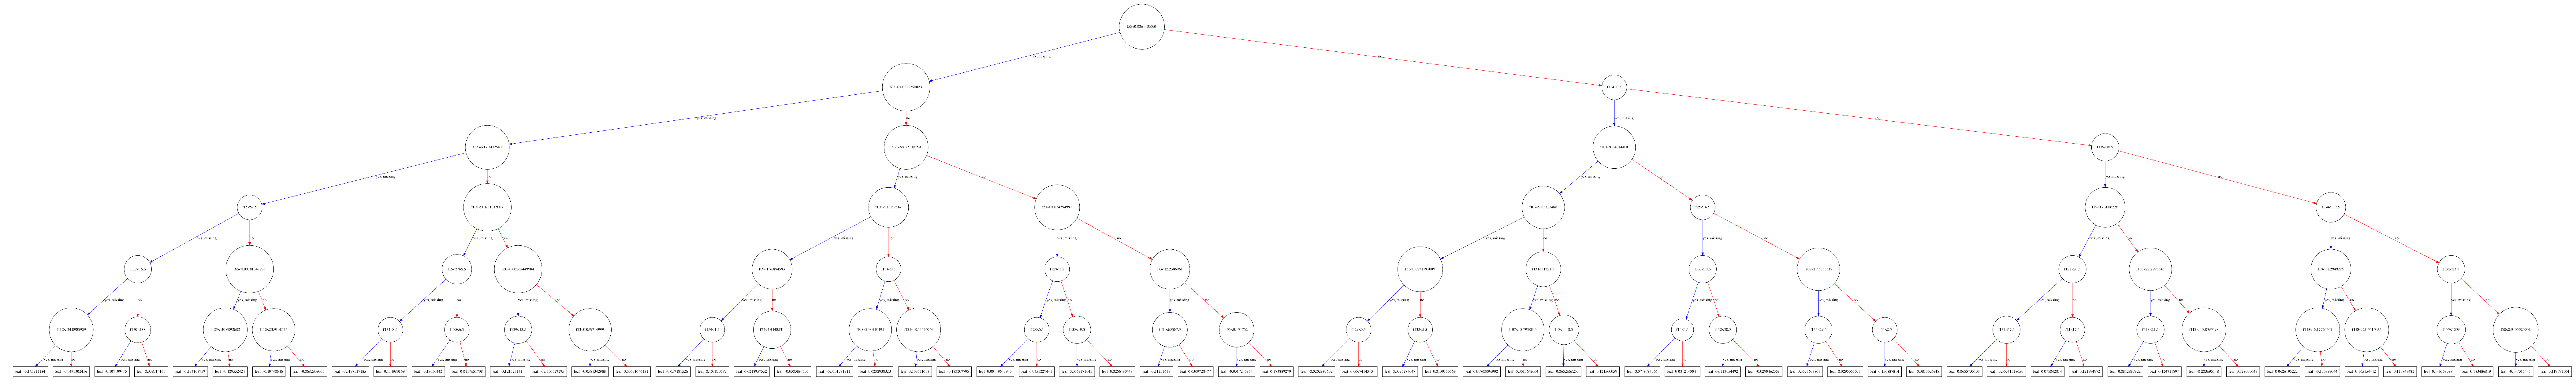

In [7]:
xgb.plot_tree(model, num_trees=3)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)

## Making predictions

In [8]:
preds = model.predict(testing_data)

In [9]:
preds

array([0.5705693 , 0.13573161, 0.23310575, ..., 0.92486215, 0.21065465,
       0.03313828], dtype=float32)

'preds' contains predicted relelvance values for all of the queries in the testing data set. We want to compute the normalised discounted cumulative gain, or ndgc, of the results, in order to quantify the goodness of the model. This will allow us to compare models and tuning parameters. 

In [ ]:
#Load in the group information 

In [51]:
""" this returns 0 if all of the ordered data is undesirable"""
def ndcg_p(ordered_data, p):
    """normalised discounted cumulative gain"""
    if sum(ordered_data)==0:
        return 0
    else:
        indexloop = range(0, p)
        DCG_p = 0
        for index in indexloop:
            current_ratio=(2**(ordered_data[index])-1)*(math.log((float(index)+2), 2)**(-1))
            DCG_p = DCG_p + current_ratio
        ordered_data.sort(reverse=True)  
        K = len(ordered_data)
        indexloop = range(0, K)
        iDCG_p = 0
        for index in indexloop:
            current_ratio=(2**(ordered_data[index])-1)*((math.log((index+2), 2))**(-1))
            iDCG_p = iDCG_p + current_ratio
        return(DCG_p/iDCG_p)

In [32]:
f = open('../LearningToRank/MSLR-WEB10K/Fold1/test_dat.txt.group', 'r')
x = f.readlines()
groups =[]
for line in x:
    groups.append(int(line))
f.close()

In [31]:
testing_labels = testing_data.get_label()

In [71]:
## compute ndgc for each query.
nquerys=range(0,len(groups))
lower=0
upper=0
ndcgs=[]
for i in nquerys:
        many=groups[i]
        upper = upper+many
        predicted = preds[lower:upper]
        labled = testing_labels[lower:upper]
        ordered = [x for _,x in sorted(zip(predicted,labled), reverse=True)]
        result = ndcg_p(ordered, many)
        ndcgs.append(result)
        lower=upper


In [76]:
ndcgs

[0.7920157908597824,
 1.0,
 0.6696320897097504,
 0.4321311307627513,
 0.7292906799182761,
 0.6709282865041498,
 0.691977589084363,
 0.7248029847160538,
 0.6512841556481817,
 0.6584181249793338,
 0.7931044654204512,
 0.7140440037630282,
 0.5299368731205177,
 0.7289583293534868,
 0.5178860488063297,
 0.6043998367862156,
 0.6168015795138558,
 0.7214322338470472,
 0.6664498435766764,
 0.8321509327629493,
 0.748022769969937,
 0.5659253563929745,
 0.4679105405562421,
 0.6204817213175754,
 0.6542312112248714,
 0.8605408459568462,
 0.5940894742008946,
 0.8929481249055113,
 0.7986348707604983,
 0.7352827419758698,
 0.6876827756396034,
 0.57081082540348,
 0.840700010240868,
 0.6278070773819843,
 0.7461264011771848,
 0.7496393488919593,
 0.755671783029136,
 0.735555095566083,
 0.712369081330788,
 0.6215891997769276,
 0.7774298203824601,
 0.6738304325753472,
 0.6569343651317164,
 0.7811538776127928,
 0.6877652955089816,
 0.7863754032241544,
 0.7645244536900541,
 0.8616372683133378,
 0.580663213768